In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split

from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, Input, MaxPool2D
from keras.regularizers import l1
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import cv2
# import os

In [2]:
images = []
ages = []
genders = []

for i in os.listdir('../input/utkface-new/crop_part1/')[0:8000]:
    split = i.split('_')
    ages.append(int(split[0]))
    genders.append(int(split[1]))
    images.append(Image.open('../input/utkface-new/crop_part1/' + i))

In [3]:
images = pd.Series(list(images), name = 'Images')
ages = pd.Series(list(ages), name = 'Ages')
genders = pd.Series(list(genders), name = 'Genders')

df = pd.concat([images, ages, genders], axis=1)
df

,Images,Ages,Genders
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,26,0
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,21,1
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,17,1
3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,76,0
4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,18,1
...,...,...,...
7995,<PIL.JpegImagePlugin.JpegImageFile image mode=...,3,0
7996,<PIL.JpegImagePlugin.JpegImageFile image mode=...,28,0
7997,<PIL.JpegImagePlugin.JpegImageFile image mode=...,10,0
7998,<PIL.JpegImagePlugin.JpegImageFile image mode=...,8,1


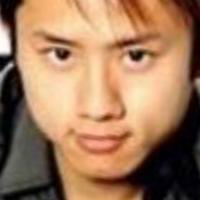

26 0


In [4]:
display(df['Images'][0])
print(df['Ages'][0], df['Genders'][0])

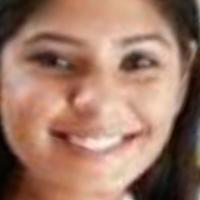

21 1


In [5]:
display(df['Images'][1])
print(df['Ages'][1], df['Genders'][1])

So 0 corresponds to male, 1 corresponds to female.

# <h1 id= 'visual'><span class="label label-default" style="background-color:#D18358; font-size:20px">3. Visualising and Preparing Data</span></h1>

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Ages', ylabel='Density'>

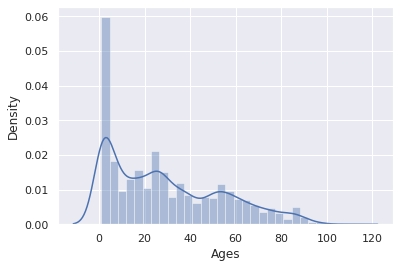

In [6]:
sns.set_theme()
sns.distplot(df['Ages'],kde=True, bins=30)

Too many faces of people between 0 and 4 years old. The model would fit too well to these ages and not enough to the other ages. To resolve this I'm only going to include a third of the images between these ages.

In [7]:
under4s = []

for i in range(len(df)):
    if df['Ages'].iloc[i] <= 4:
        under4s.append(df.iloc[i])
under4s = pd.DataFrame(under4s)
under4s = under4s.sample(frac=0.3)

df = df[df['Ages'] > 4]

df = pd.concat([df, under4s], ignore_index = True)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Ages', ylabel='Density'>

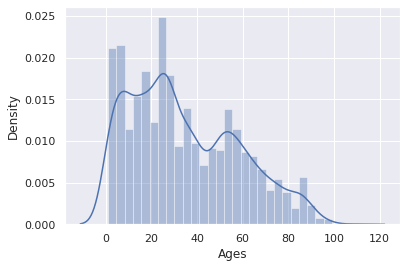

In [8]:
sns.distplot(df['Ages'],kde=True, bins=30)

This looks much better! The dataframe is more representative of the population now. However, there aren't many images of people over 80, which would cause the model to not train well enough on those ages. It's best to just remove over 80s and only have a model that can predict the ages of people under 80.

In [9]:
df = df[df['Ages'] < 80]

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Ages', ylabel='Density'>

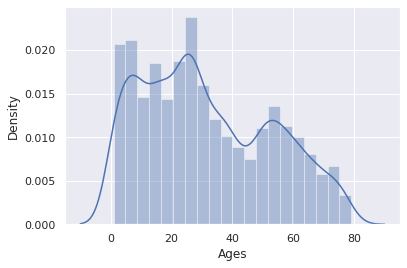

In [10]:
sns.distplot(df['Ages'],kde=True, bins=20)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Genders', ylabel='count'>

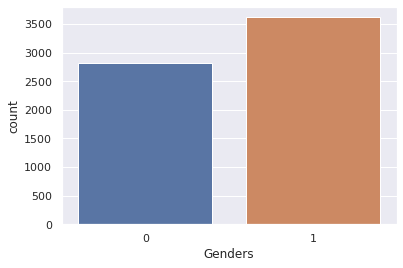

In [11]:
sns.countplot(df['Genders'])

Not sure what 3 corresponds to - both genders, no gender, unknown, or just an error in the data entry? To be safe, I am going to remove any rows where gender equals 3.

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Genders', ylabel='count'>

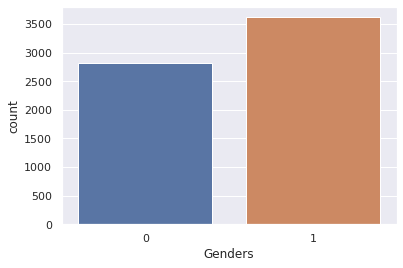

In [12]:
df = df[df['Genders'] != 3]
sns.countplot(df['Genders'])

In [13]:
x = []
y = []

for i in range(len(df)):
    df['Images'].iloc[i] = df['Images'].iloc[i].resize((200,200), Image.ANTIALIAS)
    ar = np.asarray(df['Images'].iloc[i])
    x.append(ar)
    agegen = [int(df['Ages'].iloc[i]), int(df['Genders'].iloc[i])]
    y.append(agegen)
x = np.array(x)

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


# <h1 id= 'split'><span class="label label-default" style="background-color:#D18358; font-size:20px">4. Train Test Split</span></h1>

In [14]:
y_age = df['Ages']
y_gender = df['Genders']

x_train_age, x_test_age, y_train_age, y_test_age = train_test_split(x, y_age, test_size=0.2, stratify=y_age)
x_train_gender, x_test_gender, y_train_gender, y_test_gender = train_test_split(x, y_gender, test_size=0.2, stratify=y_gender)

# <h1 id= 'model'><span class="label label-default" style="background-color:#D18358; font-size:20px">5. Creating the Models</span></h1>

I will create two individual models - one to predict age and one to predict gender. The age model should be capable of returning continuous values which I will round to the nearest integer, and the gender model should return a binary result.

In [15]:
agemodel = Sequential()
agemodel.add(Conv2D(32, (3,3), activation='relu', input_shape=(200, 200, 3)))
agemodel.add(MaxPooling2D((2,2)))
agemodel.add(Conv2D(64, (3,3), activation='relu'))
agemodel.add(MaxPooling2D((2,2)))
agemodel.add(Conv2D(128, (3,3), activation='relu'))
agemodel.add(MaxPooling2D((2,2)))
agemodel.add(Flatten())
agemodel.add(Dense(64, activation='relu'))
agemodel.add(Dropout(0.5))
agemodel.add(Dense(1, activation='relu'))

agemodel.compile(loss='mean_squared_error',
             optimizer=optimizers.Adam(lr=0.0001))

genmodel = Sequential()
genmodel.add(Conv2D(32, (3,3), activation='relu', input_shape=(200, 200, 3)))
genmodel.add(MaxPooling2D((2,2)))
genmodel.add(Conv2D(64, (3,3), activation='relu'))
genmodel.add(MaxPooling2D((2,2)))
genmodel.add(Conv2D(128, (3,3), activation='relu'))
genmodel.add(MaxPooling2D((2,2)))
genmodel.add(Flatten())
genmodel.add(Dense(64, activation='relu'))
genmodel.add(Dropout(0.5))
genmodel.add(Dense(1, activation='sigmoid'))

genmodel.compile(loss='binary_crossentropy',
             optimizer=optimizers.Adam(lr=0.0001),
             metrics=['accuracy'])

# <h1 id= 'train'><span class="label label-default" style="background-color:#D18358; font-size:20px">6. Training the Models</span></h1>

In [16]:
datagen = ImageDataGenerator(
      rescale=1./255., width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale=1./255)

train1 = datagen.flow(x_train_age, y_train_age, batch_size=32)

test1 = test_datagen.flow(
        x_test_age, y_test_age,
        batch_size=32)

history1 = agemodel.fit(train1, epochs=60, shuffle=True, validation_data=test1)

Epoch 1/60
161/161 [==============================] - 45s 259ms/step - loss: 739.4940 - val_loss: 463.3894
Epoch 2/60
161/161 [==============================] - 41s 257ms/step - loss: 520.2736 - val_loss: 439.7474
Epoch 3/60
161/161 [==============================] - 42s 260ms/step - loss: 515.6406 - val_loss: 393.5597
Epoch 4/60
161/161 [==============================] - 42s 258ms/step - loss: 436.2680 - val_loss: 324.0735
Epoch 5/60
161/161 [==============================] - 42s 262ms/step - loss: 387.6236 - val_loss: 300.8510
Epoch 6/60
161/161 [==============================] - 42s 260ms/step - loss: 371.6401 - val_loss: 300.6966
Epoch 7/60
161/161 [==============================] - 41s 258ms/step - loss: 360.4329 - val_loss: 397.6152
Epoch 8/60
161/161 [==============================] - 40s 251ms/step - loss: 350.1417 - val_loss: 377.6765
Epoch 9/60
161/161 [==============================] - 40s 249ms/step - loss: 355.6544 - val_loss: 255.2887
Epoch 10/60
161/161 [================

In [17]:
agemodel.save('age_model.h5')

In [18]:
datagen = ImageDataGenerator(
      rescale=1./255., width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale=1./255)

train2 = datagen.flow(x_train_gender, y_train_gender, batch_size=64)

test2 = test_datagen.flow(
        x_test_gender, y_test_gender,
        batch_size=64)

history2 = genmodel.fit(train2, epochs=60, shuffle=True, validation_data=test2)

Epoch 1/60
81/81 [==============================] - 41s 498ms/step - loss: 0.6751 - accuracy: 0.5659 - val_loss: 0.5887 - val_accuracy: 0.6988
Epoch 2/60
81/81 [==============================] - 40s 499ms/step - loss: 0.6066 - accuracy: 0.6725 - val_loss: 0.5491 - val_accuracy: 0.7259
Epoch 3/60
81/81 [==============================] - 40s 499ms/step - loss: 0.5652 - accuracy: 0.7162 - val_loss: 0.5093 - val_accuracy: 0.7477
Epoch 4/60
81/81 [==============================] - 40s 497ms/step - loss: 0.5423 - accuracy: 0.7345 - val_loss: 0.4901 - val_accuracy: 0.7725
Epoch 5/60
81/81 [==============================] - 40s 498ms/step - loss: 0.5164 - accuracy: 0.7543 - val_loss: 0.4692 - val_accuracy: 0.7880
Epoch 6/60
81/81 [==============================] - 40s 494ms/step - loss: 0.4929 - accuracy: 0.7673 - val_loss: 0.4431 - val_accuracy: 0.7974
Epoch 7/60
81/81 [==============================] - 40s 498ms/step - loss: 0.4903 - accuracy: 0.7697 - val_loss: 0.4557 - val_accuracy: 0.7950

In [19]:
genmodel.save('gen_model.h5')

Now to evaluate the models I am going to use some external images of celebrities. These celebrities are of a variety of ages and genders.

In [20]:
def process_and_predict(file):
    im = Image.open(file)
    width, height = im.size
    if width == height:
        im = im.resize((200,200), Image.ANTIALIAS)
    else:
        if width > height:
            left = width/2 - height/2
            right = width/2 + height/2
            top = 0
            bottom = height
            im = im.crop((left,top,right,bottom))
            im = im.resize((200,200), Image.ANTIALIAS)
        else:
            left = 0
            right = width
            top = 0
            bottom = width
            im = im.crop((left,top,right,bottom))
            im = im.resize((200,200), Image.ANTIALIAS)
            
    ar = np.asarray(im)
    ar = ar.astype('float32')
    ar /= 255.0
    ar = ar.reshape(-1, 200, 200, 3)
    
    age = agemodel.predict(ar)
    gender = np.round(genmodel.predict(ar))
    if gender == 0:
        gender = 'male'
    elif gender == 1:
        gender = 'female'
        
    print('Age:', int(age), '\n Gender:', gender)
    return im.resize((300,300), Image.ANTIALIAS)

In [21]:
# !wget -O random.jpg 'data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBwgHBgkIBwgKCgkLDRYPDQwMDRsUFRAWIB0iIiAdHx8kKDQsJCYxJx8fLT0tMTU3Ojo6Iys/RD84QzQ5OjcBCgoKDQwNGg8PGjclHyU3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3N//AABEIAJQAlAMBIgACEQEDEQH/xAAbAAACAgMBAAAAAAAAAAAAAAAEBQMGAAIHAf/EADkQAAIBAwMCBQEFBwMFAQAAAAECAwAEEQUSITFBBhMiUWFxFDKBkaEjJEJyscHwUmLRFjM0Q1MV/8QAGQEAAwEBAQAAAAAAAAAAAAAAAAECAwQF/8QAHxEBAQACAgMBAQEAAAAAAAAAAAECERIhAzFBUTIi/9oADAMBAAIRAxEAPwCkx67cL/Hu+M0bF4jkXPmKQPrVcf0YOzJHeojKSS2D9K53QukPiKBx68ii01W0k6OPzrnzXQ24xg1iXHPqOPpTJ0hLmB/uuPzqZSCPS2a5qt9IOjsPoaNttXuYiCJGI+aNB0DJHzXolK9RVUstcunBwu4DrWs+s6iW++EB7Bc/2/vUqkq4icVLGfM6Vz//AKgv4CH3JIB1Vl6038PeI11B2t5f2M69MHIcf89KcF6WxliRcu2figZgrE4GBUuM9TUbqT70aLYGWBScnrQssBHQ0wkQ0JMDzjrQADq6/NQlmXrmi/LKjdJIFFRyXECrhcu30p9lQwZmPpU1uqSg5Z9g+TUMs0qoSihKr1zJdG8VZZW2E8DtVcanlFp+1wp6WmGaykvlj4rKWhyTsi4YhBWiJGynMeDXrIFUnc3v1rwSKI9uW5pNEbWsB52CoJLCJjgDBosqQBk1o5ycqaCL5LIpnaa1W2ePY7OcMcLnpmjzjYzOeOtGaeiT3Vv5gDomSQemT0H5AUrTxghY4obZPMGQBxnv80AZomY+XAX9wqkf2q0w6S+oOIkTHZ3x+gp1a+HILBAAAffPesrk6sfH05hc+oEIrxv/AKX7/jSwu8Mwdd0bdyOtdav9LtH5eNcn4qm654dxMwt+fTn6Cqx8kTn4b8eaJ4rmUeReftiBxKTyB81dFkDKCDkEDFckaP7Hdkja7K3AxkV0bQbz7bpsUvAx6cA5xitXLlNUxdqCvn2wSMvBA4NEOaB1Bv3aX+WhKlF7qR/tEkjtGGIxu6U6t5VeIMpGKg0mNXs2DDqTSq5kksLkqmdmcgVRHk8noNKNS6LIP4TW6agkkeXzQ17dKYti85pkOjk3oGBHSvKRC4kUYVsCso0SxR+tSSSK32bgAGraOLIyCeKkUqq/7s1m2DMShxI4wPeozKN3G3FGSxK4BbvQTwuHbYBtoDXAcBdvU4px4ZRZJhEV483Off2pLghQQeRVx8I2ykwDHqZh/XrU5emnjm6u+kaf5Nng8yMcmiptNmZc5z3xUOs3BsrYJE4GxcsQCcflUHhbUlum3SSyMWGVZu4+n4Vjx26+X4in08uvqFIr6ykik81MkgY/CrZ4h1G30tgDzvHAqsXGrRFkDs+ZM7UXGT+mP1qdVXJzfxTEqX5Krt7n5pv4LlZYpYTyn3w3z7Vv47s4oxb3UDbo5F4OKj8FKn2GVwTv34Px/ma6cPTi801ksjH3oLUD+7S/y0SzUFqJ/dZf5atiTaNj7J9Sag1q2EsJkGMivdInRbXbnnJqe4KujAntTSCto4ms1IUcdaB1QRRxgDAet7W6WFJY3bgHIpZcStcTFuvPANMkWM1lFCwmIB96yjYWhULA7TgDrWshUJ8+9borerDEfWopEYJjOTWbV47Ekbzx2oeSZvUFAINbSsVZQ7D8qhJDMcdKIE+neUt7GZgNhOG5966DoVkLHW0tsHaN2zI+lcxJWumeE/E9hqQsLa9BXV4z5ayAemUAHn4O0fpU5zpr4sp6q136+UGzGsiP1DihbCziWXz4sLxgIFxim9zNEsQDqCTWkccfkrh1XJ/h61lHZ8U3xujia3JyRyOOah05IzAu+KOTb9xiMFf8zVg8VwWn2E+Y7BlwUI7e9AeH57GaAWzkeaOj+4+am7ipJVN8aRqmnLHGSFR8gHtmhPCNo9vYyO3SV8gfQVZPE9nA98IJQWAOQo/iIxjNQxxrEgRFAUdAK28Xpxef+njUDqH/AIsv8tHPQGon90l/lrVzqnY2LSqZVcpk9KluIrqJG9YYVBa6qsEBjK5IJrSfVWeMgDk1SSuUksR1Oealt1ZXD7CQKgyc7m6nrR0d7Gg2gcUEn+3Sf/A1lRfbUrKQWaQspJ3cVruBjJ4zRJjd15xgVBMNsWEIzUtAc6qWy2OKG2MWOzGCKMl7b8GhjIAxKsBRobQtGR2FF6Lc/YNYs7wnHlTKxx7dD+maGLA9+ajIHOe4xT0N6rvcyrdWWYpMM4GyQdj71Bp8FxA00WqSrKBzFOsHUdw2O9C6C7v4espk9QeBSQOxx/Sm8N5GYgoyQeAQP0rnx1HdLvom1RdMWLPnRlSeRsY7env/AJxSDQlljuJp7kxrCz4hiRcYGeMnuasOoG22lpU2gdN1U+S8eS7KqMImdg7UXv0vKzGDNSl+038khxgekf5+VDmvYx6ffnmvStb4zU08/PLldoWoK8UtC6jqRR7ihpBmqQpU2jTbyQwGagOkz+4q3zR5NCtFTSq7aTcfFRHS7ge1WsxVE0VAVf8A/NuPisqymKsoBmVm8vGFUd6gVMR+oZOaPCMEcPih5MKvB5J4xS00A3IwvJHPSlrA5ODxV60fwXeagPtGotJbW68hAv7R/p7CnL+F9DSMgWwiOOHuHLZPyQeKXoe3LYYJJ5RHDG8j9dqKSatGn+DL03ESXxVE2iRgDk9fu/X3+tWGz8nRWkt7O2jjVv8Au49TuD3DdxRsE6sm0Mdmco45Kmpt3NLxx1d0+0qEQ2iRIAqqNoAHGK9Gn/tjJbuIz/EjDKn6e1b2EyMipwHx09/pRP3Hzn0nqay1r26Ny+ibVrK8eyYO0OBn1Ak4/pVCt1AmkUDPqPJ7/wCZrpesSAWkgyNpHvXLr2ZobuHYSFeTDfj0oxv+hn3ibxjKityKihkOwFgc47VPkEV0SxxXGxDItDSLRrdKgdc09JBPHmoGh5pgUrQoM0aAAw1G0VMtg+KjMWTjFPRbL/JrKY/Z/pXlPQ2kgtL24mEMUDSyP0RBkmrboHhj7CFu9QiU3S8xxsMrGff5P9KJ8DRzR2t1fyhV8/CRnHIA+9+uB+FMbyYMTukHHTPFS0CXV66ZzIwk/wBzZB/uKU3l2ksfmsOejrnhx7H5HY1tqV2rIYL0Foz0cffjPupFV15XjZo2ZWAPVRwy9mFZ2tMY3uw0TMiscx+uI+46/wBKIhuNoWUEBHAyOwzQ0jbooJB1Vf6cf0NboBCuDgxqcEHujVHbTcPLe4KYAPHsen50xW8kMZQsRkcZGcVXbeQwSmBzuXAZSf4l96ZxSGEA/fiPO1u1UlHfrq08YjjltmU99xB/LFV240hvP864cFUcMiL7gdzVyeFJ4fMtzjikkzKdylSHHBzS4w+d1oDHEwiJPY8GprceYPmpG+5IR0YgCst18u5Hs1BNntm2ZoN+FJ9qczOEmgJ+6wIP1pLI4BfP1/OtMKyzn1R9S8S3sF3LEoAVTgZpdL4j1EjIYAH4rXXlzqsoHc1reRpDBHFgbiMmtGaWy1u+kuUEkxI3VfbZ98YJNc8MENusciNls1c4JS8EaK2Cw60y0YtdwodpzmsoCSKYNwyGspclcXap4bTTrWO1tEEcMS7R3P60gv7+BA3G41vqF68pZmP4VVtQuGL4zXNl5fx1YeH9RapNFcEhSVz0HzSPdJHMqOcjlf8APyFGSsHyCfxrWa3doIpmXlmwD2PvSl2dxkSQuGjVM8c0QuHgKt12lT9O1BAGMgfNFBthz2NUWmys0+mLKOZbUnd8r3FNLC4WaHB6Y60q0yQQ3kkbco/UfWpVU2Nw0X/rPKfSgqe2U3kOUboelZqdksw86I+odaESQOMg8ijYbg7Qrc09kR5KttYc1Jna8Z+aL1G1DftE6/FAo2Rg9RSAjUpP3eCT/S4/Xik7tuhL/QfpR16+bBgeqkH9aAiGYJF+AacvZWdVUzYC710+Z91efrSvUra6fUSWhcQq4Ue2M0z1C9bTtT83GcjtQeo+JLi5QosaKD3xXQ5kevWotLmFo/8AtsoPHvVg0qaJoozKe1U6XUJ50CStux3xTnRnZotzHhR3pW6VjNrcZrHuDn61lI1YuM5f8Kyp5L4OhXF+sikKTzSa5kLNQ8U7Ada8d9x+a4ndY9jUyOEAySas09irR2MC8qrMTj4U/wB6g8L6Z58xllGNqFlGOp4/5qwrEov0jRfSsT4P02j+5rTGMrVJ1KExOePumvUXzIAR1FMddhz5jAd6A0xtwZDVEBclJ1foc05Ki8tVb+NeRS3UISh/WpdIuNjbSaAkt5ih2vwaYRy8ZFQ3tp5g82P8RUFrMY22txQk1jnBG1qX3cWyXenQ0YYQy7gailDMmG7UyAXnNuw9xQWnEOzA9xijrsfsWHxSzSTl/wAaD+Kp4njH2gZHQ80qgtVmjPGPmn/iuEjUmU/dIDYpWJNqBVHAra+unP1ssnsnhOeoqW0uHi4Q4FTysWHPSvPLUR9KO6NyD11ZwoA2jArKVpaOy596yjjT5xewcCitOQTXaK/QmsrK4o73WdEtIYtH9CYLNtJ+KFaJU1IqOQtu2M/zCsrK6fjln1XdXjX9px2quadxdYHTNZWVK8R+sxIEDY5pHakrPx71lZSCz2Z3R885oa8gjBLAc15WUEJ01iyENyBW0qgZrKyiEBuVGxxjtVRlu5bWM+TgH3I+a9rKueyvolvJZJpd8rl2IySaFPSvaytWFRkV4/TFZWUEJiJCCvKysph//9k='

In [24]:
!wget -O newone.jpg 'https://www.shutterstock.com/image-photo/curious-scrupulous-male-model-trendy-260nw-748837144.jpg'
img = cv2.cvtColor(cv2.imread("/kaggle/working/newone.jpg"), cv2.COLOR_BGR2RGB)

--2024-06-27 14:33:58--  https://www.shutterstock.com/image-photo/curious-scrupulous-male-model-trendy-260nw-748837144.jpg
Resolving www.shutterstock.com (www.shutterstock.com)... 18.239.36.81, 18.239.36.6, 18.239.36.57, ...
Connecting to www.shutterstock.com (www.shutterstock.com)|18.239.36.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20860 (20K) [image/jpeg]
Saving to: ‘newone.jpg’

newone.jpg          100%[===================>]  20.37K  --.-KB/s    in 0s      

2024-06-27 14:33:58 (225 MB/s) - ‘newone.jpg’ saved [20860/20860]



In [25]:
img.shape

(280, 390, 3)

Text(0.5, 1.0, 'Age: 26 gender: Female')

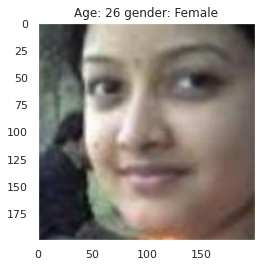

In [26]:
import matplotlib.pyplot as plt
import random
i = random.randint(0, len(x))

img = x[i]
plt.imshow(img)
plt.grid(False)
age_pred = agemodel.predict(np.array([img])/255)
# print(age_pred)
age = int(age_pred[0][0])

gen_pred = genmodel.predict(np.array([img])/255)
# print(gen_pred)
gen = "Male" if gen_pred[0][0] < 0.5 else "Female"
plt.title(f'Age: {age} gender: {gen}')

Age: 27 
 Gender: male


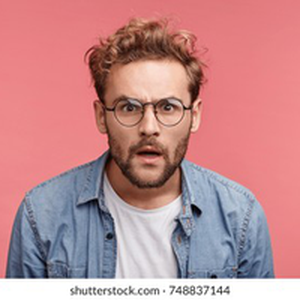

In [27]:
process_and_predict('/kaggle/working/newone.jpg')

In [28]:
! pip install mtcnn

     |████████████████████████████████| 2.3 MB 10.9 MB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [29]:
from mtcnn import MTCNN
import cv2

In [30]:
img = cv2.cvtColor(cv2.imread("/kaggle/working/newone.jpg"), cv2.COLOR_BGR2RGB)
print(img.shape)
detector = MTCNN()
detections = detector.detect_faces(img)
detections

(280, 390, 3)


[{'box': [154, 60, 80, 105],
  'confidence': 0.9999918937683105,
  'keypoints': {'left_eye': (175, 99),
   'right_eye': (212, 99),
   'nose': (194, 120),
   'mouth_left': (180, 142),
   'mouth_right': (206, 143)}}]

In [32]:
def mod_box(box):
    
    x, y, w, h = box
    cx, cy = x + w/2,  y + h / 2
    if h > w:
        x = int(cx - h / 2)
        w = int(h)
    elif w > h:
        y = int(cy - w / 2)
        h = int(w)
    if x < 0:
        x = 0
    if y < 0: 
        y = 0
    return x, y, w, h

141 60 105 105


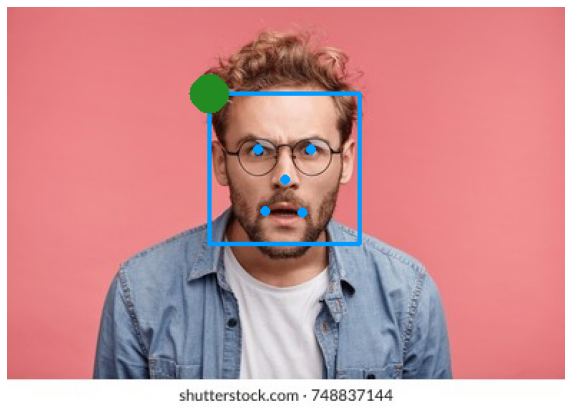

In [33]:
import matplotlib.pyplot as plt

img_with_dets = img.copy()
min_conf = 0.9
for det in detections:
    if det['confidence'] >= min_conf:
        x, y, width, height = mod_box(det['box'])
#         x, y, width, height = det['box']
        print(x,y,width,height)
        keypoints = det['keypoints']
        cv2.rectangle(img_with_dets, (x,y), (x+width,y+height), (0,155,255), 2)
        cv2.circle(img_with_dets, (keypoints['left_eye']), 2, (0,155,255), 2)
        cv2.circle(img_with_dets, (keypoints['right_eye']), 2, (0,155,255), 2)
        cv2.circle(img_with_dets, (keypoints['nose']), 2, (0,155,255), 2)
        cv2.circle(img_with_dets, (keypoints['mouth_left']), 2, (0,155,255), 2)
        cv2.circle(img_with_dets, (keypoints['mouth_right']), 2, (0,155,255), 2)
        cv2.circle(img_with_dets, ((x,y)), 2, (34,139,34), 23)
plt.figure(figsize = (10,10))
plt.imshow(img_with_dets)
plt.axis('off')
plt.show()

In [34]:
def find_center_imgs(img,detections,min_conf = 0.9):
    cropped_images = []
    for det in detections:
        if det['confidence'] >= min_conf:
            x, y, width, height = mod_box(det['box'])
            tem_img = img/255
            cropped_images.append(cv2.resize(tem_img[y:y+height,x:x+width,:], (200, 200)))
    return cropped_images

In [35]:
cropped_images = find_center_imgs(img, detections, 0.9)

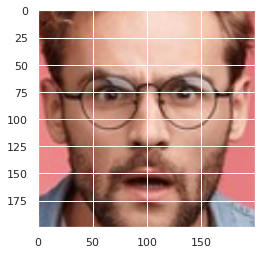

In [36]:
t = cropped_images[0]
plt.imshow(t)


In [37]:
agemodel.predict(np.array(cropped_images))

array([[23.245447]], dtype=float32)

In [38]:
emotion_path = '/kaggle/input/ckplus/CK+48'

In [39]:
os.listdir(emotion_path)

['surprise', 'fear', 'sadness', 'disgust', 'contempt', 'happy', 'anger']

In [40]:
emotion_imgs = []
emotions = []

for cl,dir in enumerate(os.listdir(emotion_path)):
    imgs = os.listdir(f'{emotion_path}/{dir}')
    for i in range(0, len(imgs)):
        emotion_imgs.append(f'{dir}/{imgs[i]}')
        emotions.append(cl)

In [42]:
df = pd.DataFrame()
df['image'] = emotion_imgs
df['emotion'] = emotions

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='emotion', ylabel='count'>

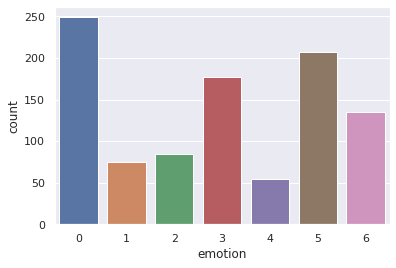

In [43]:
sns.countplot(df['emotion'])

In [44]:
df['emotion'].value_counts()

0    249
5    207
3    177
6    135
2     84
1     75
4     54
Name: emotion, dtype: int64

In [45]:
df.groupby('emotion').count()

,image
emotion,
0,249
1,75
2,84
3,177
4,54
5,207
6,135


In [46]:
t = Image.open(f'{emotion_path}/{df.image.iloc[2]}')
t.size

(48, 48)

In [47]:
x = []
y = []

for i in range(len(df)):
#     df['image'].iloc[i] = df['image'].iloc[i].resize((48,48), Image.ANTIALIAS)
#     ar = np.asarray(df['images'].iloc[i])
#     x.append(ar)
#     agegen = [int(df['Ages'].iloc[i]), int(df['Genders'].iloc[i])]
#     y.append(agegen)
    img = Image.open(f'{emotion_path}/{df.image.iloc[i]}')
    img = np.asarray(img).reshape(48,48,1)
    x.append(img)
    y.append(int(df['emotion'].iloc[i]))
x = np.array(x)
y = np.array(y)

In [48]:
x.shape, y.shape

((981, 48, 48, 1), (981,))

In [49]:
x_train, x_test, y_train, y_test = train_test_split(x,y,shuffle = True)

In [50]:
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

In [51]:
y_test.shape

(246, 7)

In [52]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

In [53]:
def create_model():
    input_shape=(48,48,1)

    model = Sequential()
    model.add(Conv2D(6, (5, 5), input_shape=input_shape, padding='same', activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(16, (5, 5), padding='same', activation = 'relu'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(7, activation = 'softmax'))

    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='RMSprop')
    
    return model

In [54]:
em_model = create_model()

In [ ]:
# em_model.save('/kaggle/input/emotion/emotion_model.h5')

In [55]:
traine = train_datagen.flow(x_train, y_train, batch_size=8)

teste = test_datagen.flow(
        x_test, y_test,
        batch_size=4)

In [56]:
# resnet = tf.keras.applications.ResNet50
his = em_model.fit(traine, epochs = 40, validation_data=teste)

Epoch 1/40
92/92 [==============================] - 2s 9ms/step - loss: 1.8847 - accuracy: 0.1847 - val_loss: 1.7188 - val_accuracy: 0.4553
Epoch 2/40
92/92 [==============================] - 1s 7ms/step - loss: 1.7449 - accuracy: 0.3368 - val_loss: 1.2533 - val_accuracy: 0.5813
Epoch 3/40
92/92 [==============================] - 1s 7ms/step - loss: 1.4231 - accuracy: 0.4554 - val_loss: 1.0423 - val_accuracy: 0.6016
Epoch 4/40
92/92 [==============================] - 1s 7ms/step - loss: 1.2184 - accuracy: 0.5386 - val_loss: 0.8594 - val_accuracy: 0.6951
Epoch 5/40
92/92 [==============================] - 1s 7ms/step - loss: 1.1689 - accuracy: 0.5603 - val_loss: 0.7306 - val_accuracy: 0.7805
Epoch 6/40
92/92 [==============================] - 1s 7ms/step - loss: 1.0511 - accuracy: 0.6126 - val_loss: 0.6447 - val_accuracy: 0.7846
Epoch 7/40
92/92 [==============================] - 1s 7ms/step - loss: 0.9232 - accuracy: 0.6624 - val_loss: 0.5490 - val_accuracy: 0.8333
Epoch 8/40
92/92 [==

In [57]:
em_model.save('emotion_model.h5')

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

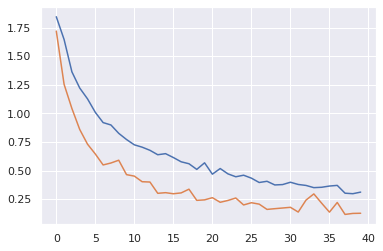

In [58]:
import matplotlib.pyplot as plt
plt.plot(his.history['loss'])
plt.plot(his.history['val_loss'])
his.history.keys()

In [59]:
def tran(img):
    img = img*255
    img = img.astype('uint8')
    resized_image = cv2.resize(img, (48, 48))
    gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)

    final_image = np.expand_dims(gray_image, axis=-1)
    
    return final_image

(48, 48, 1)

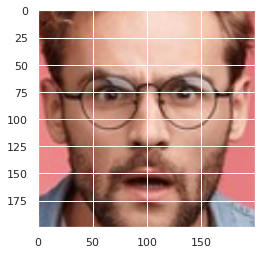

In [60]:

plt.imshow(cropped_images[0])

t = [tran(img) for img in cropped_images]
t[0].shape
# plt.imshow(t[2])
# len(cropped_images)

In [61]:
classes = os.listdir(emotion_path)

In [62]:
classes

['surprise', 'fear', 'sadness', 'disgust', 'contempt', 'happy', 'anger']

In [63]:
x_train_age.shape, y_train_age.shape

((5152, 200, 200, 3), (5152,))

In [64]:

def inference(image):
    detector = MTCNN()
    detections = detector.detect_faces(image)
#     print(len(detections))
    cropped_images = find_center_imgs(image, detections, 0.9)
#     print(cropped_images)
    ages = agemodel.predict(np.array(cropped_images)).astype(int)
    genders = genmodel.predict(np.array(cropped_images))
    genders = [0 if gen < 0.5 else 1 for gen in genders]
    
    emotion_imgs = [tran(img) for img in cropped_images]
    emotions = em_model.predict(np.array(emotion_imgs)).argmax(axis=1)
    
    plt.figure()
    
    
    gens = ["Male" if i == 0 else "Female" for i in genders]
    ems = [classes[i] for i in emotions]
    
    print(ages)
    print(["Male" if i == 0 else "Female" for i in genders])
    print([classes[i] for i in emotions])
    
    bboxes = [det['box'] for det in detections]
    
    for bbox, age, gen, em in zip(bboxes, ages, gens, ems):
        x, y, w, h = bbox
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        text = f'Age: {age}, Gender: {gen}, Emotion: {em}'
        cv2.putText(image, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
    
    return bboxes, ages, gens, ems

In [65]:
# !wget -O multiple2.jpg 'https://img.freepik.com/free-photo/people-with-glasses-composition_23-2150188060.jpg'
img = cv2.cvtColor(cv2.imread("/kaggle/working/newone.jpg"), cv2.COLOR_BGR2RGB)


[[23]]
['Male']
['disgust']


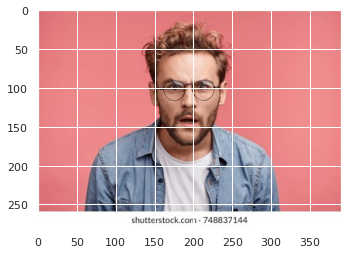

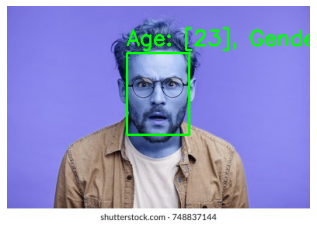

([[154, 60, 80, 105]], array([[23]]), ['Male'], ['disgust'])

In [66]:
plt.imshow(img)
inference(img)